In [105]:
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

from one.api import ONE
from iblatlas.atlas import AllenAtlas
import iblatlas.plots as anatomyplots

from psyfun import io, plots, atlas
from psyfun.config import *

In [46]:
ONE.setup(base_url='https://alyx.internationalbrainlab.org')

Param ALYX_LOGIN, current value is ["davide.crombie"]: 
Param HTTP_DATA_SERVER, current value is ["https://ibl.flatironinstitute.org"]: 
Param HTTP_DATA_SERVER_LOGIN, current value is ["iblmember"]: 
Enter the FlatIron HTTP password for iblmember (leave empty to keep current):  ········
Enter the location of the download cache, current value is ["/home/davide/Downloads/ONE/alyx.internationalbrainlab.org"]: 
Would you like to set this URL as the default one? [Y/n] Y
Are the above settings correct? [Y/n] Y


ONE Parameter files location: /home/davide/.one


IBLParams(CLIENT_MAP={'alyx.internationalbrainlab.org': '/home/davide/Downloads/ONE/alyx.internationalbrainlab.org'}, DEFAULT='alyx.internationalbrainlab.org')

# Database query

#### Run the script to fetch data
This can be run in a terminal in the background: python3 fetch_data.py -a

In [ ]:
# Fetch everything
# %run -i fetch_data.py -a

In [50]:
# Fetch session metadata
%run -i fetch_data.py -s

Fetching sessions...


  4%|████████▊                                                                                                                                                                                            | 2/45 [00:00<00:04,  9.55it/s]

  7%|█████████████▏                                                                                                                                                                                       | 3/45 [00:00<00:06,  6.17it/s]

 11%|█████████████████████▉                                                                                                                                                                               | 5/45 [00:02<00:28,  1.40it/s]local md5 mismatch on dataset: mainenlab/Subjects/ZFM-08457/2025-03-20/001/raw_task_data_02/_iblrig_taskSettings.raw.json

(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-20/001/raw_task_data_02/_iblrig_taskSettings.raw.json:   0%|                                             | 0.00/4.00k [00:00<?, ?B/s]
(S3) /home/davide/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-20/001/raw_task_data_02/_iblrig_taskSettings.raw.json: 100%|████████████████████████████████████| 4.00k/4.00k [00:00<00:00, 11.3kB/s]
local md5 mismatch on dataset: mainenlab/Subjects/ZFM-08457/2025-03-20/001/raw_task_data_02/_iblrig_stimPositionScreen.raw.csv

(S3) /home/davide/Downloads/ONE/alyx.internation

In [ ]:
# Fetch insertion metadata
# %run -i fetch_data.py -i

In [ ]:
# Fetch unit info and spike times
# %run -i fetch_data.py -t

#### Manually fetch data using psyfun.io

In [ ]:
# Instantiate database connection
# one = ONE()

# Query the database for all sessions associated with this project
# df_sessions = io.fetch_sessions(one, save=True)

# Query the database for all probe insertions associated with this project
# df_insertions = io.fetch_insertions(one, save=True)

# Quality control

#### Load session and insertion info from file

In [103]:
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

#### Check raw and extracted datasets for each session

TODO: 
- check task 2 '_ibl_passivePeriods.intervalsTable.csv're-extraction, timings currently from other sources

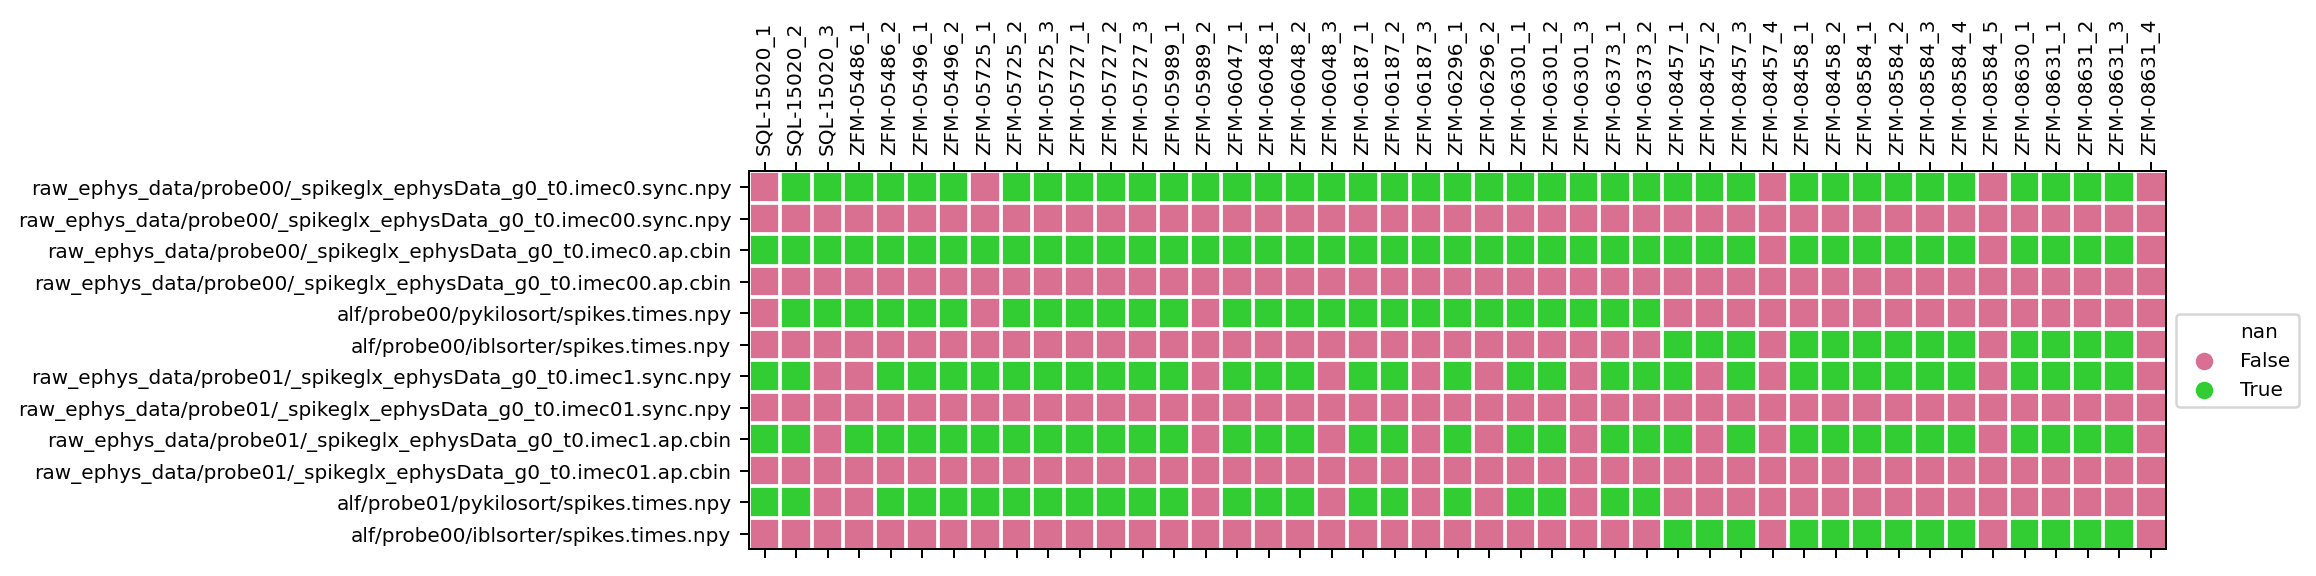

In [64]:
# Check which task datasets exist for each session
# Pick a data modality
dsets = 'ephys'  # 'task', 'ephys', 'video
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']  # label each session with the mouse ID and session number
ax = plots.qc_grid(df_sessions, qc_datasets[dsets], qcval2num=qcval2num, xticklabels=xticklabels)
plots.set_plotsize(w=20)

#### Overview of available sessions

In [74]:
# Note: rather than checking the raw datasets, we just check if we were able to find protocol timings with io._fetch_protocol_timings
tasks = ['task00_spontaneous_start', 'task00_rfm_start', 'task00_replay_start', 'LSD_admin', 'task01_spontaneous_start', 'task01_rfm_start', 'task01_replay_start']
df_sessions['task_ok'] = df_sessions.apply(lambda x: all([not np.isnan(x[task]) for task in tasks]), axis='columns')

# Check for spike sorted data set for each probe
ephys = ['alf/probe01/pykilosort/spikes.times.npy', 'alf/probe01/pykilosort/spikes.times.npy', 'alf/probe00/iblsorter/spikes.times.npy', 'alf/probe01/iblsorter/spikes.times.npy']
df_sessions['ephys_ok'] = df_sessions.apply(lambda x: any([x[dset] for dset in ephys]), axis='columns')  # note: here we use 'any' rather than 'all'

# List of all checks to be applied
checks = ['task_ok', 'ephys_ok']
df_sessions['all_ok'] = df_sessions.apply(lambda x: all([x[check] for check in checks]), axis='columns')

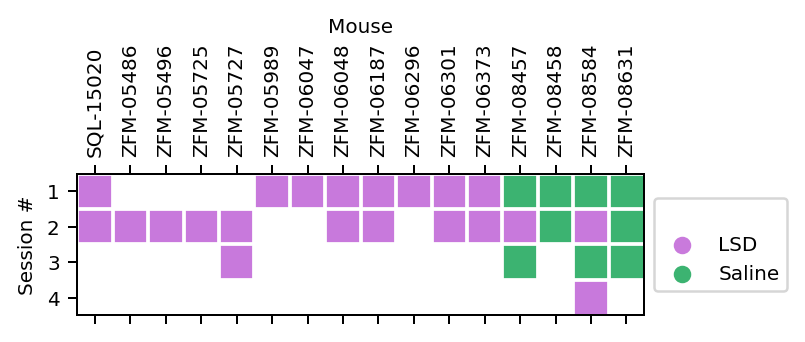

In [84]:
# Pivot sessions table (filtered the checks above) to plot it as a sessions x subjects matrix
sessions_pivot = df_sessions.query('all_ok == True').pivot(columns='session_n', index='subject', values='control_recording')
sessions_pivot = sessions_pivot.rename_axis(None, axis='columns')

# Make a custom color map
cmap = colors.LinearSegmentedColormap.from_list(
    'rec_type',
    [(0., 'white'), (0.01, LSDCOLOR), (1., CONTROLCOLOR)],
)
# Plot the sessions x subjects grid
ax = plots.qc_grid(sessions_pivot, qcval2num={np.nan: 0., False: 0.01, True: 1.}, cmap=cmap)

# Add a legend with informative labels
legend = ax.get_legend()
for label, text in zip(legend.get_texts(), ['', 'LSD', 'Saline']):
    label.set_text(text)
# legend.set_visible(False)  # uncomment to hide legend

# Format axes
ax.set_xticklabels(sessions_pivot.index)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Mouse')
ax.xaxis.set_label_position('top')
ax.set_ylabel('Session #')
plots.set_plotsize(w=8, h=4)

In [1]:
# Merge insertion trajectory labels
df_sessions.apply(lambda x: '_'.join([str(x['t1']), str(x['t2'])]), axis='columns')

NameError: name 'df_sessions' is not defined

> /tmp/ipykernel_2098497/3597992714.py(2)<module>()
      1 # Merge insertion trajectory labels
----> 2 df_sessions.apply(lambda x: '_'.join([str(x['t1']), str(x['t2'])]), axis='columns')



ipdb>  c


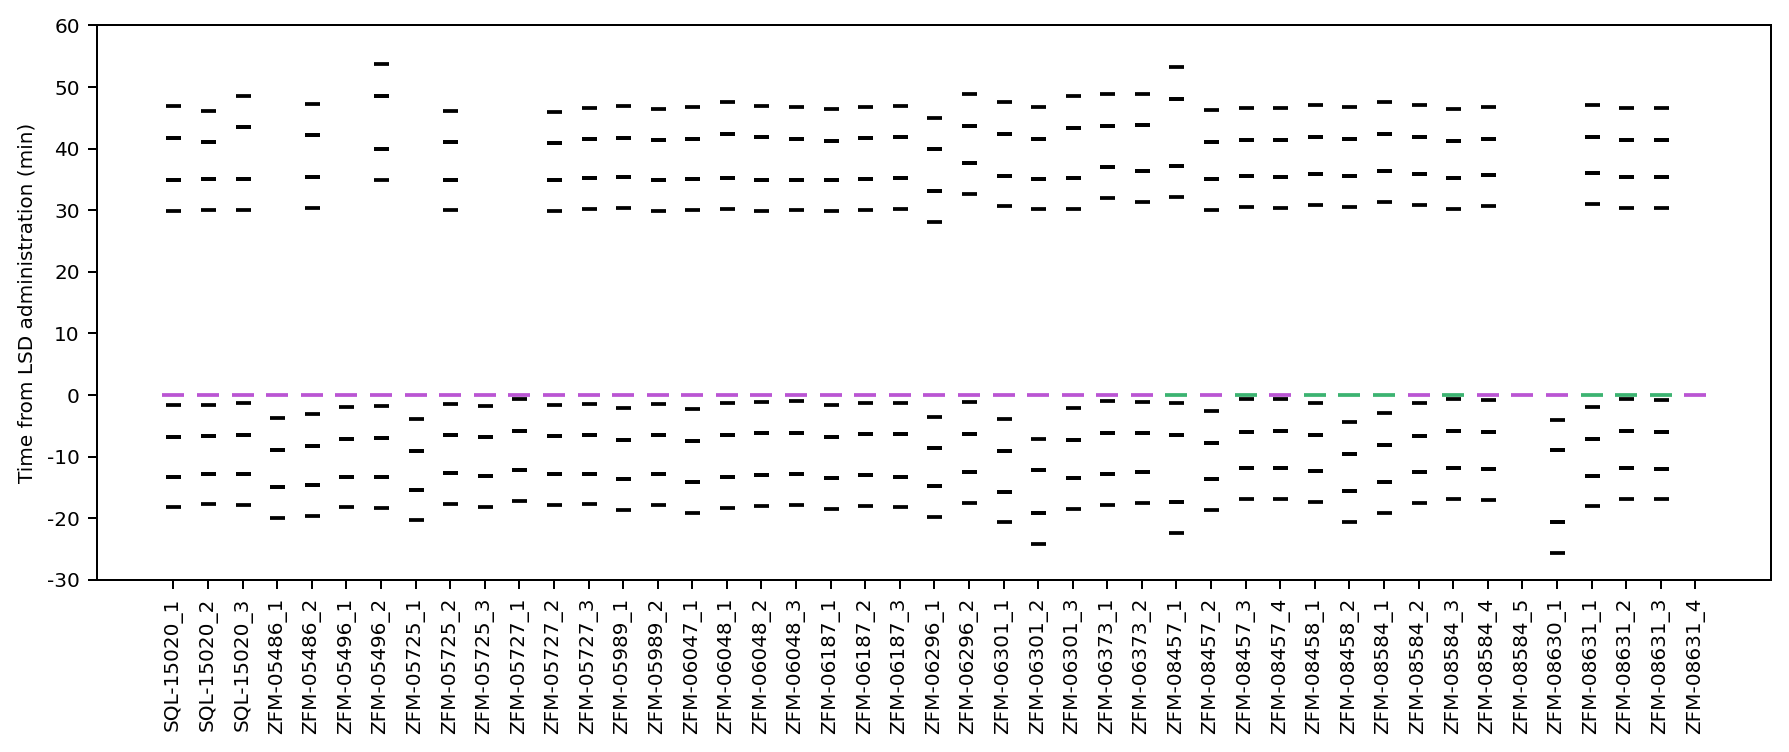

In [79]:
# Plot protocol timings for all sessions
epochs = ['spontaneous', 'rfm', 'replay']
fig, ax = plt.subplots(figsize=(12, 4))
for idx, session in df_sessions.iterrows():
    t0 = session['LSD_admin']
    if session['control_recording']:
        ax.scatter(idx, 0, marker='_', s=80, color=CONTROLCOLOR)
    else:
        ax.scatter(idx, 0, marker='_', s=80, color=LSDCOLOR)
    for task in ['task00', 'task01']:
        for epoch in epochs:
            ax.scatter(idx, session[f'{task}_{epoch}_start'] - t0, marker='_', color='black')
            ax.scatter(idx, session[f'{task}_{epoch}_stop'] - t0, marker='_', color='black')
ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-30, 60, 10) * 60)
ax.set_yticklabels(np.linspace(-30, 60, 10).astype(int))
ax.set_ylabel('Time from LSD administration (min)')

#### Detailed QC

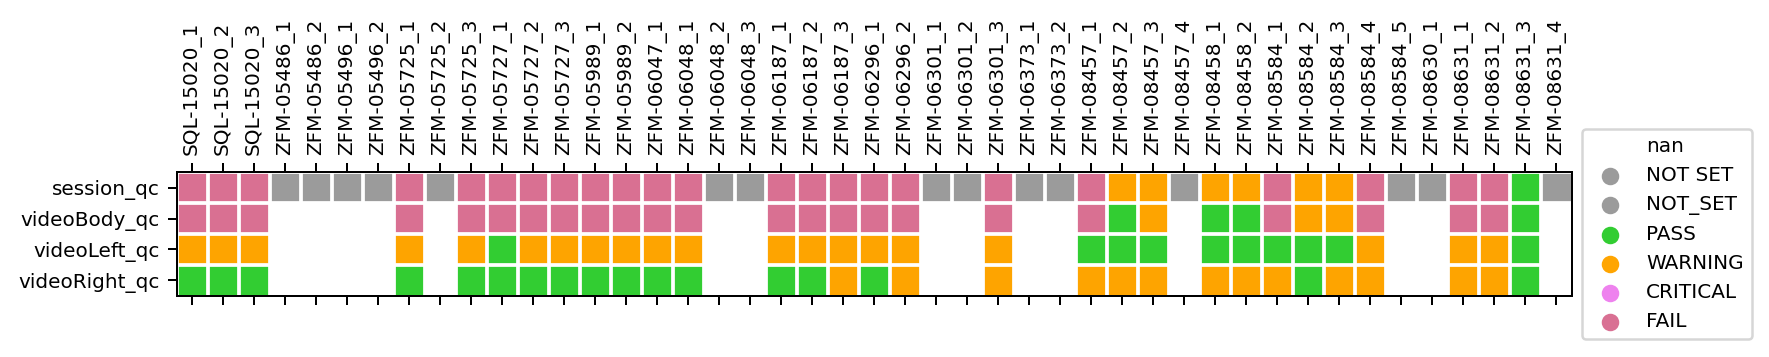

In [78]:
# Plot QC summary
qc_columns = ['session_qc', 'videoBody_qc', 'videoLeft_qc', 'videoRight_qc']
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, xticklabels=xticklabels)
ax.get_figure().set_figwidth(10)

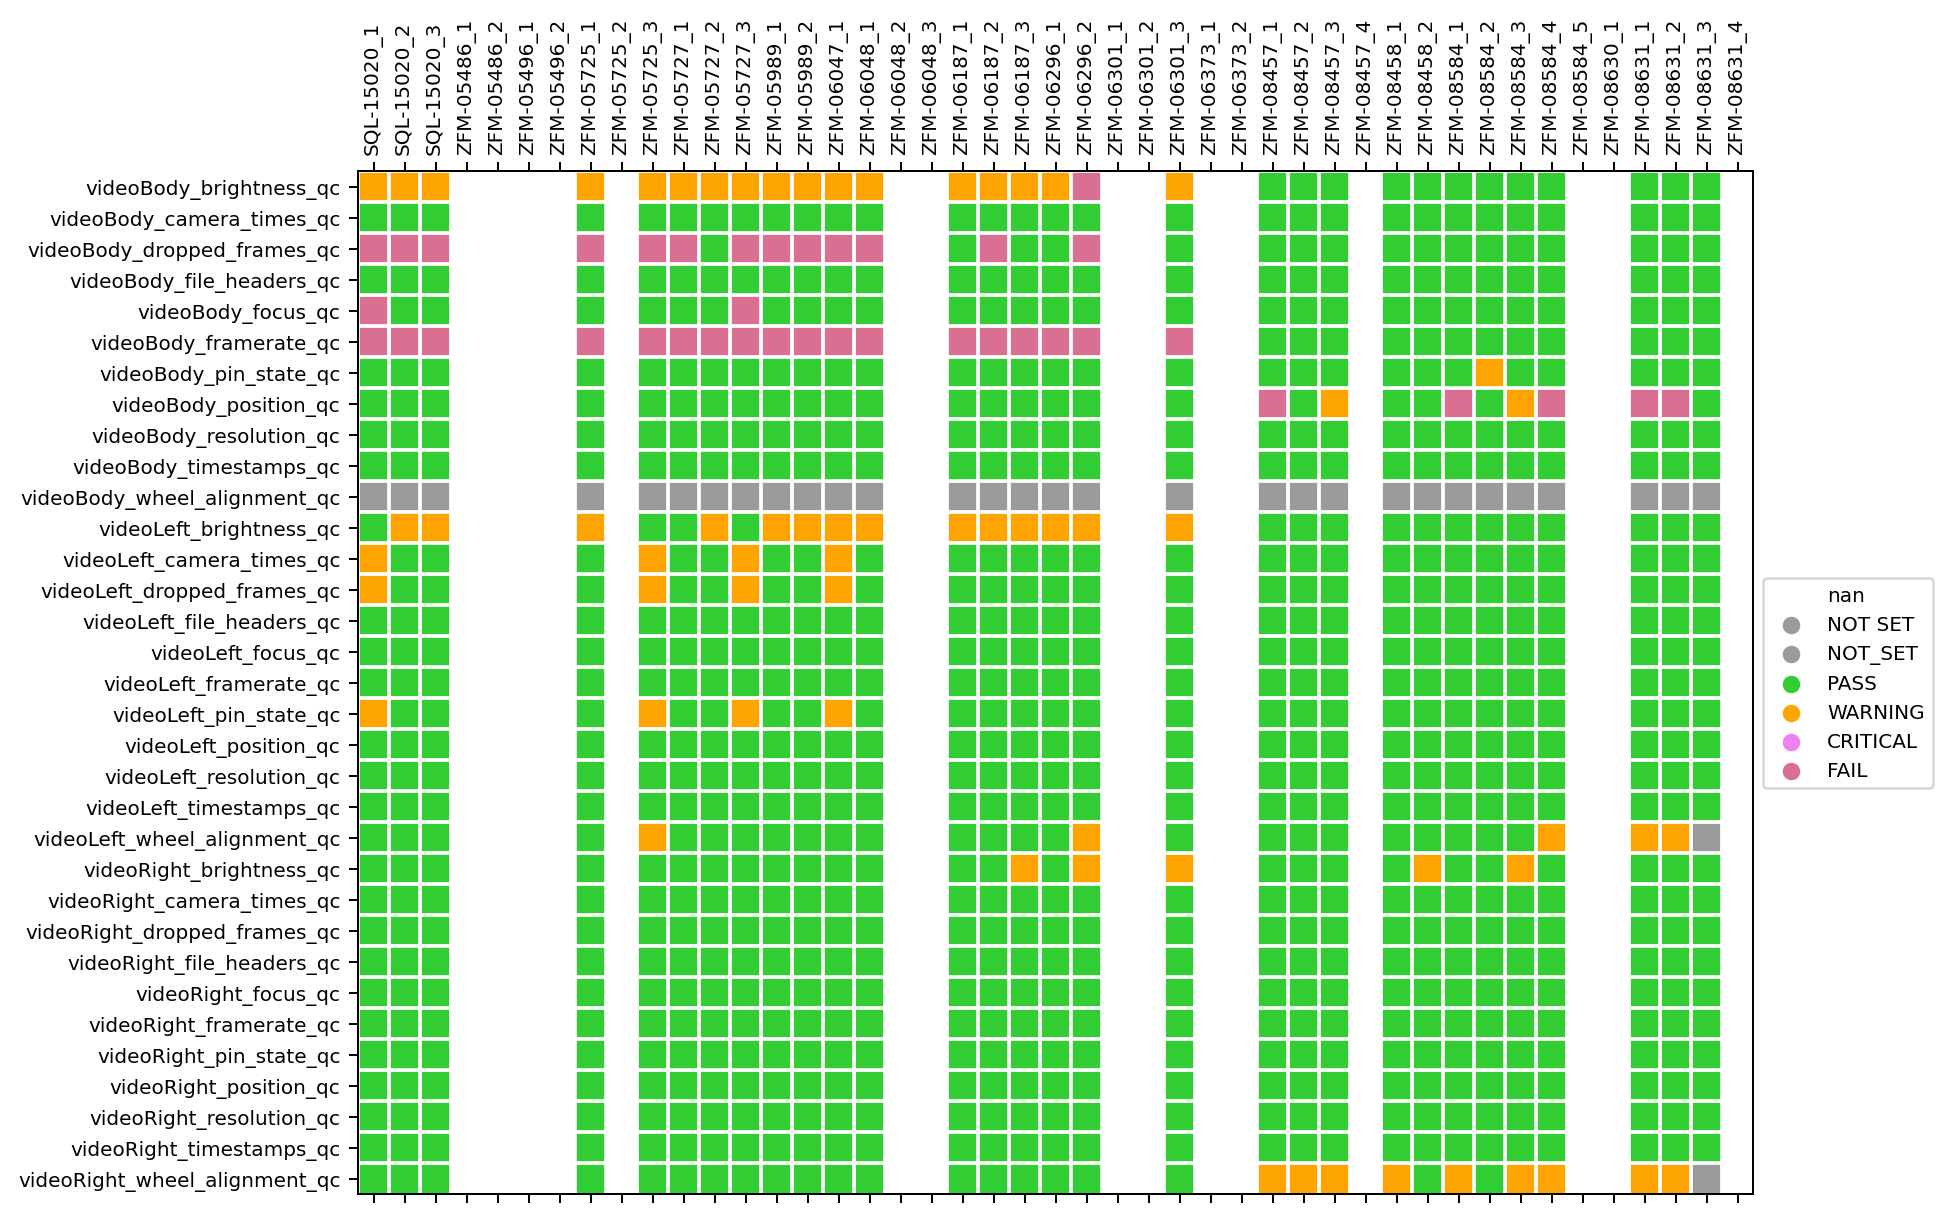

In [77]:
# Plot detailed QC for each session
fig, ax = plt.subplots(figsize=(6, 8))
qc_columns = [col for col in df_sessions.columns if ('qc' in col) & (col.count('_') > 1)]
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, ax=ax, xticklabels=xticklabels)
ax.get_figure().set_figwidth(10)

In [ ]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)

In [ ]:
# Plot detailed ephys QC for ech session/probe
fig = plt.figure(figsize=(12, 6))
axs = [
    fig.add_axes([0.1, 0.5, 0.8, 0.3]),
    fig.add_axes([0.1, 0.1, 0.8, 0.45])
]

# Sort by subject
df_insertions = df_insertions.sort_values(['subject', 'session_n', 'probe'])

# QC grid plot
qc_columns = [col for col in df_insertions.columns if col.endswith('_qc')]
xticklabels = ['subject', 'session_n', 'probe']
axs[0] = plots.qc_grid(df_insertions, qc_columns, ax=axs[0], xticklabels=xticklabels)


# Bar plots for N units and firing rates
ax2 = axs[1].twinx()
xpos = np.arange(len(df_insertions))
offests = [-0.15, 0.15]
alphas = [0.5, 1.]
units_cols = ['n_units', 'n_units_qc_pass']
rate_cols = ['firing_rate_max', 'firing_rate_median']
for offset, units_col, rate_col, alpha in zip(offests, units_cols, rate_cols, alphas):
    n_units = df_insertions[units_col]
    axs[1].bar(xpos + offset, n_units, width=0.3, color='C0', alpha=alpha)
    firing_rate = df_insertions[rate_col]
    ax2.bar(xpos + offset, -1 * np.log10(firing_rate),  width=0.3, color='C0', alpha=alpha)
axs[1].set_xlim([-0.5, len(df_insertions) - 0.5])
axs[1].set_ylim([-2000, 2000])
axs[1].set_yticks(np.linspace(0, 2000, 5))
axs[1].set_ylabel('N units')
ax2.set_ylim([-3, 3])
ax2.set_yticks(-1 * np.linspace(0, 3, 4))
ax2.set_yticklabels(f'$10^{tick}$' for tick in np.linspace(0, 3, 4).astype(int))
ax2.set_ylabel('Firing rate (Hz)')
axs[1].axhline(0, color='black', lw=1)
axs[1].set_xticks(np.arange(len(df_insertions)))
axs[1].set_xticklabels(df_insertions.apply(lambda x: f"{x['subject']}_{x['session_n']}_{x['probe']}", axis='columns'))
axs[1].tick_params(axis='x', rotation=90)

## Anatomical distribution of neurons
#### TODO:
- check how proportions are calculated in bar plot, and apply new region sorting

In [ ]:
# Load cluster info from file, keep only good units
df_units = pd.read_parquet(paths['units']).query('ks2_label =="good"')
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])

In [ ]:
eids = df_sessions['eid'].to_list()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# # Load spike times for good units
# uuids = df_unitquery['uuid'].tolist()
# df_spiketimes = io.load_units(paths['spikes'], uuids)
# # Join spike times with unit info
# df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_units = pd.merge(df_unitquery, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_units = df_units[[col for col in df_units.columns if not col.endswith('_x') or col.endswith('_y')]]

In [ ]:
fig, ax = plt.subplots()
cmap = cmaps['n_units']

region_counts = df_units.query('control_recording == False').groupby('coarse_region').apply(len).sort_values(ascending=False)

n_regions = len(region_counts)
props = region_counts / region_counts.sum()
colors = np.array([cmap(p) for p in props / props.max()])

ax.bar(np.arange(n_regions) - 0.2, region_counts, width=0.3, fc=colors, ec='gray')
ax.set_xticks(np.arange(n_regions))
ax.set_xticklabels(region_counts.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of units')
ax.text(0.98, 0.98, f'N total = {len(df_units)}', fontsize=plots.LABELFONTSIZE, ha='right', va='top', transform=ax.transAxes)

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 0.2), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')
cbar.set_ticks([0, 0.1, 0.2])

for xpos, region in enumerate(region_counts.index):
    n_units = df_units.query('(control_recording == True) & (coarse_region == @region)').apply(len)
    color = cmap(n_units / len(df_units.query('(control_recording == True)')) / props.max())
    ax.bar(xpos + 0.2, n_units, width=0.3, color=color, ec='gray')

plots.set_plotsize(w=12, h=4)

In [ ]:
# Plot distribution of units across brain regions

## TODO: normalize contribution of units by volume of region
region_counts = df_units.groupby('region').apply(len).sort_values(ascending=False)
for ap_coord in ap_coords:
    fig, ax = anatomyplots.plot_scalar_on_slice(
        region_counts.index, 
        np.log10(region_counts.values),
        coord=ap_coord * 1000,  # in um
        background='boundary',
        atlas=AllenAtlas(res_um=50),
        clevels=[0, 4],
        cmap=cmap,
        show_cbar=False,
    )
    ax.text(0.01, 0.95, f'AP: {ap_coord}mm', fontsize=plots.LABELFONTSIZE, transform=ax.transAxes)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax_pos = ax.get_position()  # returns [left, bottom, width, height]
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0, ax_pos.y0, cbar_pos.width, ax_pos.height])
    cbar.set_ticks(np.linspace(0, 4, 5))
    cbar.set_ticklabels(['$10^{%d}$' % tick for tick in np.linspace(0, 4, 5)])
    cbar.set_label('N units')
    
    plots.set_plotsize(w=6, ax=ax)

# Control data

In [ ]:
df_bwm = io.fetch_BWM_task_starts(one)

In [ ]:
df_bwm = pd.read_csv('metadata/BWM_task_starts.csv')

In [ ]:
cutoff = 300 

fig, ax = plt.subplots()
ax.hist(df_bwm['task_start'] / 60)
ax.axvline(cutoff / 60, ls='--', color='gray')
ax.set_ylabel('Sessions')
ax.set_xlabel('Pre-task spontaneous activity')

df_controls = df_bwm.query('task_start > @cutoff')
print(f'Sessions with pre-task period > {cutoff / 60:.2f}min: {len(df_controls)}')

In [ ]:
df_insertions_bwm = io.fetch_BWM_insertions(one, df_controls)

In [ ]:
# QC grid plot
qc_columns = [col for col in df_insertions_bwm.columns if col.endswith('_qc')]
xticklabels = ['subject', 'probe']
ax = plots.qc_grid(df_insertions_bwm, qc_columns, xticklabels=xticklabels)

In [ ]:
df_insertions_bwm = pd.read_csv(paths['BWM_insertions'])

In [ ]:
len(df_insertions_bwm['eid'].unique())

In [ ]:
df_uinfo = io.fetch_unit_info(one, df_insertions_bwm, uinfo_file=paths['BWM_units'], spike_file=paths['BWM_spikes'])

In [ ]:
df_uinfo_bwm = pd.read_parquet(paths['BWM_units'])

In [ ]:
len(df_uinfo_bwm)

In [ ]:
## TODO: check if e.g. intervals table dataset exists
## TODO: ask Olivier to re-extract old task data
for eif in df_uinfo_bwm['eid'].unique():
    details = one.get_details(eid)
    print(details['task_protocol'])

In [ ]:
task_settings = one.load_dataset(eid, '_iblrig_taskSettings.raw.json')